This tutorial will show how to use numbat to do stuff while *only* making use of **three** Numbat 
functions:

- `nb.ntensor` (to create `ntensor`s)
- `nb.lift` (to lift jax functions to operate on `ntensor`s.) 
- `nb.vmap` (to vmap functions over `ntensor`s)


In [1]:
# import stuff
import numbat as nb
import jax
from jax import numpy as jnp
import numpy as onp
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [2]:
# let's start by loading my favorite MNIST and convert into ntensor format
fmnist = fetch_openml(data_id=40996, as_frame=False, parser='liac-arff')

In [3]:
# convert the data into ntensor format
#batch, height, width, cat, hidden, minibatch = nb.axes()
data   = jnp.reshape(fmnist["data"],[70000,28,28])/255.0
x      = nb.ntensor(data, 'batch', 'height', 'width')
y      = nb.ntensor(fmnist["target"].astype(int), 'batch')

In [4]:
print(x.shape)

{batch:70000, height:28, width:28}


In [5]:
print(y.shape)

{batch:70000}


In [6]:
# let's make predictions for a SINGLE input
def predict(params:dict[str,nb.ntensor], x:nb.ntensor)->nb.ntensor:
    "Given an ntensor for a SINGLE input and a parameter dictionary, compute a single output."
    assert x.axes == {'width', 'height'}
    assert params['w1'].axes == {'width', 'height', 'hidden'}
    assert params['b1'].axes == {'hidden'}
    assert params['w2'].axes == {'hidden', 'cat'}
    assert params['b2'].axes == {'cat'}
    
    H = nb.lift(jax.nn.relu)(params['w1'] @ x + params['b1'])
    out = params['w2'] @ H + params['b2']
    
    assert H.axes == {'hidden'}
    assert out.axes == {'cat'}
    return out

def logistic_loss(pred:nb.ntensor, y:nb.ntensor)->jnp.ndarray:
    "Given an ntensor of predictions and a SINGLE output, compute loss. Return as a Jax scalar."
    
    assert pred.axes == {'cat'}
    assert y.axes == set()
    
    loss = nb.lift(jax.nn.logsumexp,'cat ->')(pred) - pred(cat=y)

    assert loss.axes == set()
    return loss.numpy()

In [7]:
n_hidden = 100
params = dict()
params['w1'] = nb.ntensor(onp.random.randn(28,28,n_hidden), 'width', 'height', 'hidden')
params['b1'] = nb.ntensor(onp.random.randn(n_hidden), 'hidden')
params['w2'] = nb.ntensor(onp.random.randn(n_hidden, 10), 'hidden', 'cat')
params['b2'] = nb.ntensor(onp.random.randn(10), 'cat')

predict(params, x(batch=5))

<ntensor {cat:10} [  10.627531  -90.483055  -77.80947   -51.658047 -109.61517    52.518566
  -13.41383   108.30491  -105.74334    66.10221 ]>

In [8]:
# loss is Jax scalar, not Numbat scalar
logistic_loss(nb.ntensor(jnp.zeros(10), 'cat'), y(batch=0))

Array(2.3025851, dtype=float32)

In [9]:
def estimate_loss(params:dict[str,nb.ntensor], key:jax.random.PRNGKey)->jnp.ndarray:
    "Given dict of params and Jax PRNGKey, draw random input and output, make predictions, compute loss"
    b = jax.random.randint(key, (), 0, 70000)
    my_x = x(batch=b)
    my_y = y(batch=b)
    pred = predict(params, my_x)
    return logistic_loss(pred, my_y)


key = jax.random.PRNGKey(0)
estimate_loss(params, key)

def estimate_loss_batched(params:dict[str,nb.ntensor], key:jax.random.PRNGKey)->jnp.ndarray:
    """Given dict of params and Jax PRNGKey, draw a BUNCH of inputs, estimate all losses, take mean.
    Note we use regular jax.map since key is jax array
    """
    keys = jax.random.split(key, 10)
    losses = jax.vmap(estimate_loss, [None, 0])(params, keys)
    return jnp.mean(losses)

estimate_loss_batched(params, key)

Array(106.34755, dtype=float32)

In [10]:
g = jax.grad(estimate_loss_batched)(params, key)
{key: g[key].shape for key in g}

{'b1': ShapeDict(hidden=100),
 'b2': ShapeDict(cat=10),
 'w1': ShapeDict(width=28, height=28, hidden=100),
 'w2': ShapeDict(hidden=100, cat=10)}

In [11]:
def sgd(params:dict[str,nb.ntensor], step, momentum):
    #key = nb.ntensor(jax.random.PRNGKey(0),'i')
    key = jax.random.PRNGKey(0)
    avg_loss = 0
    grad_fun = jax.value_and_grad(estimate_loss_batched)
    avg_g = {name:params[name]*0 for name in params}
    
    def next(i, key, params, avg_loss, avg_g):
        key, subkey = jax.random.split(key)
        loss, g = grad_fun(params, subkey)
        beta = nb.lift(jnp.maximum)(momentum, 1/(1+i))
        avg_g = {name: (1-beta)*avg_g[name] + beta*g[name] for name in params}
        params = {name:params[name] - step*(avg_g[name]) for name in params}        
        alpha = jnp.maximum(.01, 1/(i+1))
        avg_loss = (1-alpha)*avg_loss + alpha*loss
        return key, params, avg_loss, avg_g
    
    next = jax.jit(next)
    
    for i in range(250):
        key, params, avg_loss, avg_g = next(i, key, params, avg_loss, avg_g)
    return params, avg_loss

optimized_params, avg_loss = sgd(params, .01, .1)
avg_loss

Array(15.3943405, dtype=float32)

In [12]:
steps = nb.ntensor(2.0**-jnp.arange(0.5, 7, 0.5), 'step')
moms  = nb.ntensor(2.0**-jnp.arange(0, 8, 2), 'mom')
print(f"{steps=}")
print(f"{moms=}")

steps=<ntensor {step:13} [0.70710677 0.5        0.35355338 0.25       0.17677669 0.125
 0.08838835 0.0625     0.04419417 0.03125    0.02209709 0.015625
 0.01104854]>
moms=<ntensor {mom:4} [1.       0.25     0.0625   0.015625]>


In [13]:
# batch across all steps sizes and all momentums
_, avg_loss = nb.vmap(sgd, in_axes={'step','mom'})(params, steps, moms)

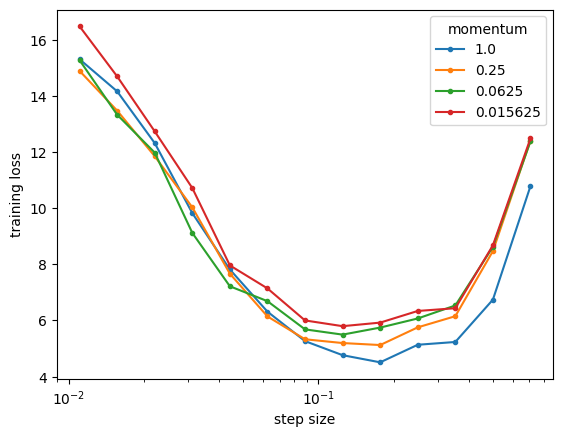

In [14]:
plt.semilogx(jnp.array(steps), avg_loss.numpy('step', 'mom'), '.-')
plt.xlabel('step size')
plt.ylabel('training loss')
plt.legend(jnp.array(moms), title='momentum')
plt.show()